In [25]:
import numpy as np
#from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# for the random seed
import tensorflow as tf

# set the random seeds to get reproducible results
np.random.seed(1)
tf.set_random_seed(2)

# Load data from https://www.openml.org/d/554
#X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


import numpy as np
tmp = np.load('mnist.npz')
X = tmp['X']
y = tmp['y']
X, y = X[:1000], y[:1000]
X = X.reshape(X.shape[0], 28, 28, 1)

# Normalize
X = X / 255.
# number of unique classes
num_classes = len(np.unique(y))
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)


num_tot = y.shape[0]
num_train = y_train.shape[0]
num_test = y_test.shape[0]

y_oh = np.zeros((num_tot, num_classes))
y_oh[range(num_tot), y] = 1

# Print out a few rows of y.
print('Rows of y', y[0:5] )
# Print out a few rows of y_oh.
print('Rows of y_oh after np.zeros transformation ', y_oh[0:5] )

y_oh_train = np.zeros((num_train, num_classes))
y_oh_train[range(num_train), y_train] = 1

y_oh_test = np.zeros((num_test, num_classes))
y_oh_test[range(num_test), y_test] = 1

Rows of y [5 0 4 1 9]
Rows of y_oh after np.zeros transformation  [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adagrad
import tensorflow
from keras.callbacks import *
from clr_callback import *
import timeit
%matplotlib inline
import matplotlib.pyplot as plt


model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.))
model.add(Conv2D(32, (3, 3), activation='relu'))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.))
model.add(Dense(10, activation='softmax'))


In [27]:
clr_triangular = CyclicLR(base_lr=1, max_lr=6,
                                step_size=100.,mode = 'triangular')

# Compile the model
model.compile(optimizer = Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(X_train, y_oh_train, validation_data=(X_test, y_oh_test) , batch_size=32, epochs=20, callbacks=[clr_triangular], verbose=2)

Train on 800 samples, validate on 200 samples
Epoch 1/20
 - 1s - loss: 1.7162 - acc: 0.4350 - val_loss: 1.1309 - val_acc: 0.6750
Epoch 2/20
 - 1s - loss: 0.6365 - acc: 0.8038 - val_loss: 0.5910 - val_acc: 0.8350
Epoch 3/20
 - 1s - loss: 0.3206 - acc: 0.9025 - val_loss: 0.4207 - val_acc: 0.8600
Epoch 4/20
 - 1s - loss: 0.3139 - acc: 0.9050 - val_loss: 0.3581 - val_acc: 0.9050
Epoch 5/20
 - 1s - loss: 0.1491 - acc: 0.9537 - val_loss: 0.2785 - val_acc: 0.9350
Epoch 6/20
 - 1s - loss: 0.0670 - acc: 0.9825 - val_loss: 0.2553 - val_acc: 0.9400
Epoch 7/20
 - 1s - loss: 0.0179 - acc: 0.9975 - val_loss: 0.3071 - val_acc: 0.9400
Epoch 8/20
 - 1s - loss: 0.0079 - acc: 0.9988 - val_loss: 0.3039 - val_acc: 0.9400
Epoch 9/20
 - 1s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.3087 - val_acc: 0.9400
Epoch 10/20
 - 1s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3678 - val_acc: 0.9350
Epoch 11/20
 - 1s - loss: 0.0106 - acc: 0.9975 - val_loss: 0.3976 - val_acc: 0.9350
Epoch 12/20
 - 1s - loss: 0.0566 - acc:

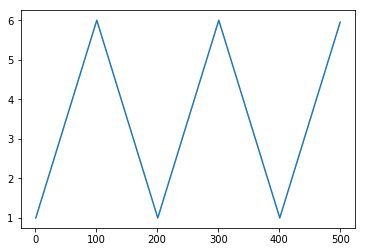

In [29]:
plt.plot(clr_triangular.history['iterations'],clr_triangular.history['lr'])

# The learning rate is in [1,6]

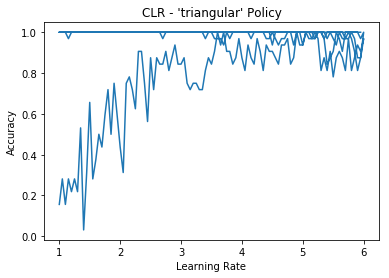

In [30]:
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['lr'],clr_triangular.history['acc'])

Text(0.5, 0, 'Learning Rate')

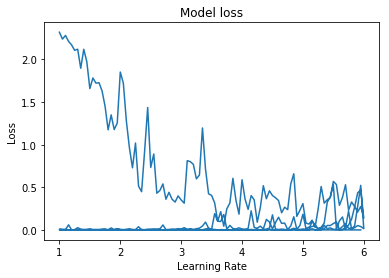

In [31]:
plt.plot(clr_triangular.history['lr'], clr_triangular.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Learning Rate') 

In [ ]:
# According to the Model loss graph above, the loss decreases significantly
# when learning rate is bewteen 1 to 4.
# I can assume that the optiam learning rate range for Adadelta is in [1, 4].

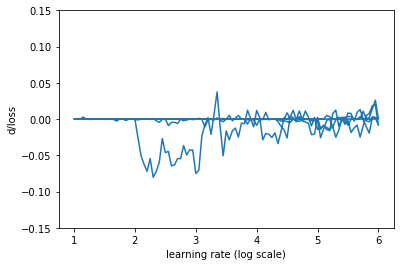

In [32]:
# To plot change in loss function 
# by calculating the derivative of the loss function - loss change graph
# use sma to eliminate the noise in the graph below


def plot_loss_change(lrlist, losslist, sma=1, n_skip=20, y_lim=(-0.15,0.15)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(lrlist)):
        derivative = (losslist[i] - losslist[i - sma]) / sma
        derivatives.append(derivative)

    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(lrlist[n_skip:], derivatives[n_skip:])
    #plt.xscale('log')
    plt.ylim(y_lim)

plot_loss_change(clr_triangular.history['lr'], clr_triangular.history['loss'], sma=20)

In [ ]:
# The minimal d/loss value appears when learning rate is around 3.15 or 2.3
# It means that the loss function decreases most significantly when lr = 3.15 or 2.3
# I test these two values in Adadelta.ipynb to see which is the optimal one.